In [13]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import timm
import torch
import torchvision

from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class MyDataset(Dataset):
    def __init__(self, ):
        translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",\
  "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",\
"scoiattolo": "squirrel",  "cavallo": "horse",\
  "farfalla":"butterfly",
  "ragno":"spider", }
        self.to_index={ "{}".format(con):i for i,con in enumerate(translate.values()) }
        print(self.to_index)
        path="/kaggle/input/animals10/raw-img"
        kk=[]
        labels=[]
        for root,dir,name in  os.walk(path):
            if(len(dir)==0):
                label=root.split("/")[-1]
                label=translate[label]
                for na in name:
                    tp_path=os.path.join(root,na)
                    kk.append(tp_path)
                    labels.append(label)

        self.path= kk
        self.labels = labels
        
    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        tp_path = self.path[idx]
        image=Image.open(tp_path).convert("RGB") 
        
        transform_to_tensor =  transforms.Compose([transforms.Resize((224,224)),\
                       transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        image = transform_to_tensor(image)
        label = self.labels[idx]
        label=self.to_index[label]
        file_name=tp_path
        return image, label,file_name
my_dataset = MyDataset()
dataloader = DataLoader(my_dataset, batch_size=64, shuffle=True)

{'dog': 0, 'horse': 1, 'elephant': 2, 'butterfly': 3, 'chicken': 4, 'cat': 5, 'cow': 6, 'sheep': 7, 'squirrel': 8, 'spider': 9}


In [ ]:
phar=tqdm(total=len(dataloader))
for i,(image, label,c) in enumerate(dataloader):
    
    print(image.size())
    phar.update()
    

# # # ***Train***

  0%|          | 0/410 [00:00<?, ?it/s]

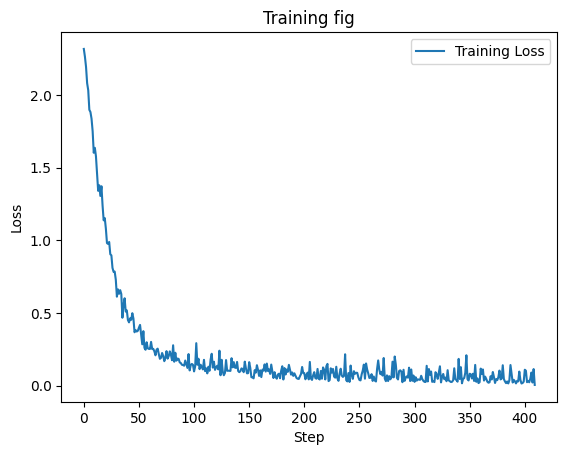

  0%|          | 0/410 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:

model = timm.create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=10)



# 冻结模型参数
for param in model.parameters():
    param.requires_grad = False


total_epoch = 4
# 将最后的分类头设置为可训练
for param in model.head.parameters():
    param.requires_grad = True

# 使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=0.0007)


# 训练模型
def train_model(model, train_loader, criterion, optimizer, epoch):
    model.train()
    step_loss=[]
    running_loss = 0.0
    phar = tqdm(total=len(train_loader))
    total=0
    correct=0
    for i,(images, labels,_) in enumerate(train_loader):
       
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        
        #test accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        step_loss.append(loss.detach().cpu())

        running_loss += loss.item()
        phar.set_description("epoch:{} loss:{:.4f} accuracy:{:.4f} " \
                             .format(epoch, loss,100 * correct / total))
        phar.update()
    epoch_loss = running_loss / len(train_loader)
    phar.close()
    return step_loss,epoch_loss



def plot_loss(loss,flag1,flag2,i):
    plt.figure()
    save_path="./{}.png".format(i)
    plt.plot(loss, label='Training Loss')
    xlab="Epoch" if flag1==1 else "Step"
    ylab="Loss"  if flag2==1 else "Accuracy"
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title('Training fig')
    plt.legend()
    plt.savefig(save_path)
    plt.show()
epoch_loss_fig=[]
acc_fig=[]
i=0
resume=False
if resume==True:
    state=torch.load("sxd.pth")
    model.state_dict(state)
    

for epoch in range(total_epoch):
    step_loss,epoch_loss=train_model(model, dataloader, criterion, optimizer, epoch)
    torch.save(model.state_dict(),"sxd2.pth")
    
    plot_loss(step_loss,0,1,i)
    epoch_loss_fig.append(epoch_loss)
    i+=1
plot_loss(epoch_loss_fig,1,1,i)
i+=1
